In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

N_CLUSTERS = 2
FRAME_SIZE = (224, 224)  

def extract_resnet_features(frame, model, device):

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(FRAME_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    frame = transform(frame).unsqueeze(0).to(device)

    with torch.no_grad():
        features = model(frame)
    return features.cpu().numpy().flatten()

def process_video_frame_by_frame(video_path, model, device):
    cap = cv2.VideoCapture(video_path)
    features_list = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        features = extract_resnet_features(frame, model, device)
        features_list.append(features)

    cap.release()
    return np.array(features_list)

def cluster_features(features, n_clusters=N_CLUSTERS):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features)
    return kmeans.labels_, kmeans.cluster_centers_

def visualize_clusters(features, labels, output_plot_path, n_clusters=N_CLUSTERS):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features)

    plt.figure(figsize=(10, 6))
    for i in range(n_clusters):
        cluster_points = reduced_features[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

    plt.legend()
    plt.title('Clusters of Video Frames Based on ResNet-18 Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.savefig(output_plot_path)
    plt.close()
    print(f'Plot saved to {output_plot_path}')

def save_frame_cluster_assignments_to_csv(frame_labels, output_csv_path):
    df = pd.DataFrame({'Frame': np.arange(len(frame_labels)), 'Cluster': frame_labels})
    df.to_csv(output_csv_path, index=False)
    print(f'Frame cluster assignments saved to {output_csv_path}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18 = models.resnet18(pretrained=True)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])  
resnet18 = resnet18.to(device)
resnet18.eval()

input_csv_path = '/content/Frame-level_LBP - Sheet1.csv'
df_videos = pd.read_csv(input_csv_path)

df_videos_to_process = df_videos[df_videos['Misclassification Rate'].isna() &
                                 df_videos['Misclassification Rate(%)'].isna() &
                                 df_videos['Precision'].isna()]

output_plot_dir = '/content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT'
output_csv_dir = '/content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV'
os.makedirs(output_plot_dir, exist_ok=True)
os.makedirs(output_csv_dir, exist_ok=True)

for index, row in tqdm(df_videos_to_process.iterrows(), total=df_videos_to_process.shape[0], desc='Processing videos'):
    video_id = row['Video_ID']  
    region = row['Region']  
    video_path = f'/content/drive/Shareddrives/mBSUS/Data/Raw Data/mbsus_case_videos/{video_id}_{region}.mp4'

    if not os.path.exists(video_path):
        print(f"Video {video_path} not found.")
        continue

 
    resnet_features = process_video_frame_by_frame(video_path, resnet18, device)

 
    frame_labels, _ = cluster_features(resnet_features)

    
    output_plot_path = os.path.join(output_plot_dir, f'{video_id}_{region}_cluster_plot.png')
    visualize_clusters(resnet_features, frame_labels, output_plot_path)

    output_csv_path = os.path.join(output_csv_dir, f'{video_id}_{region}_frame_cluster_assignments.csv')
    save_frame_cluster_assignments_to_csv(frame_labels, output_csv_path)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]
Processing videos:   0%|          | 0/53 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/010-0_RLS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/010-0_RLS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:   4%|▍         | 2/53 [01:11<29:30, 34.71s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/014-0_LLS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/014-0_LLS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:   6%|▌         | 3/53 [01:43<27:49, 33.39s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/014-0_LLT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/014-0_LLT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:   8%|▊         | 4/53 [02:02<22:46, 27.90s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/014-0_LPT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/014-0_LPT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:   9%|▉         | 5/53 [02:35<23:52, 29.83s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/015-0_LAS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/015-0_LAS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  11%|█▏        | 6/53 [03:05<23:25, 29.91s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/015-0_LPS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/015-0_LPS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  13%|█▎        | 7/53 [03:37<23:15, 30.35s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/015-0_LPT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/015-0_LPT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  15%|█▌        | 8/53 [04:09<23:18, 31.07s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/016-0_LLT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/016-0_LLT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  17%|█▋        | 9/53 [04:38<22:15, 30.36s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/017-0_LAS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/017-0_LAS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  19%|█▉        | 10/53 [05:10<22:07, 30.88s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/017-0_LAT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/017-0_LAT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  21%|██        | 11/53 [05:41<21:35, 30.85s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/019-0_LPT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/019-0_LPT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  23%|██▎       | 12/53 [05:59<18:21, 26.87s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/022-0_RAS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/022-0_RAS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  25%|██▍       | 13/53 [06:11<15:04, 22.62s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/022-0_RLT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/022-0_RLT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  26%|██▋       | 14/53 [06:35<14:51, 22.86s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/027-0_LLT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/027-0_LLT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  28%|██▊       | 15/53 [07:03<15:28, 24.42s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/027-0_LPT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/027-0_LPT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  30%|███       | 16/53 [07:18<13:22, 21.68s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/028-0_LAS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/028-0_LAS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  32%|███▏      | 17/53 [07:38<12:39, 21.10s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/028-0_LLS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/028-0_LLS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  34%|███▍      | 18/53 [07:56<11:40, 20.02s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/028-0_LLT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/028-0_LLT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  36%|███▌      | 19/53 [08:18<11:46, 20.79s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/028-0_LPS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/028-0_LPS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  38%|███▊      | 20/53 [08:37<11:10, 20.33s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/028-0_LPT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/028-0_LPT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  40%|███▉      | 21/53 [08:54<10:14, 19.19s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/028-0_RAS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/028-0_RAS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  42%|████▏     | 22/53 [09:12<09:44, 18.84s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/028-0_RLS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/028-0_RLS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  43%|████▎     | 23/53 [09:31<09:29, 18.99s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/028-0_RLT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/028-0_RLT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  45%|████▌     | 24/53 [09:55<09:53, 20.45s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/028-0_RPS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/028-0_RPS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  47%|████▋     | 25/53 [10:27<11:08, 23.87s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/028-0_RPT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/028-0_RPT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  49%|████▉     | 26/53 [10:49<10:29, 23.32s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/029-0_LAS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/029-0_LAS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  51%|█████     | 27/53 [11:07<09:24, 21.72s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/029-0_LLS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/029-0_LLS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  53%|█████▎    | 28/53 [11:27<08:52, 21.28s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/029-0_LLT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/029-0_LLT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  55%|█████▍    | 29/53 [11:44<07:56, 19.85s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/029-0_LPS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/029-0_LPS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  57%|█████▋    | 30/53 [12:05<07:48, 20.38s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/029-0_LPT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/029-0_LPT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  58%|█████▊    | 31/53 [12:31<08:04, 22.02s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/029-0_RAS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/029-0_RAS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  60%|██████    | 32/53 [12:44<06:42, 19.16s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/029-0_RLS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/029-0_RLS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  62%|██████▏   | 33/53 [13:00<06:05, 18.28s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/029-0_RLT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/029-0_RLT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  64%|██████▍   | 34/53 [13:19<05:52, 18.56s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/029-0_RPS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/029-0_RPS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  66%|██████▌   | 35/53 [13:47<06:21, 21.21s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/029-0_RPT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/029-0_RPT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  68%|██████▊   | 36/53 [14:06<05:49, 20.54s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/030-0_LAS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/030-0_LAS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  70%|██████▉   | 37/53 [14:22<05:07, 19.23s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/030-0_LLS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/030-0_LLS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  72%|███████▏  | 38/53 [14:45<05:08, 20.58s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/030-0_LLT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/030-0_LLT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  74%|███████▎  | 39/53 [15:01<04:25, 18.95s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/030-0_LPS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/030-0_LPS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  75%|███████▌  | 40/53 [15:21<04:11, 19.34s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/030-0_LPT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/030-0_LPT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  77%|███████▋  | 41/53 [15:39<03:48, 19.07s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/030-0_RAS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/030-0_RAS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  79%|███████▉  | 42/53 [15:57<03:23, 18.53s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/030-0_RLS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/030-0_RLS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  81%|████████  | 43/53 [16:20<03:20, 20.03s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/030-0_RLT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/030-0_RLT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  83%|████████▎ | 44/53 [16:36<02:49, 18.84s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/030-0_RPS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/030-0_RPS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  85%|████████▍ | 45/53 [16:51<02:20, 17.53s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/030-0_RPT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/030-0_RPT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  87%|████████▋ | 46/53 [17:00<01:46, 15.15s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/031-0_RAS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/031-0_RAS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  89%|████████▊ | 47/53 [17:16<01:32, 15.35s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/031-0_RLS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/031-0_RLS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  91%|█████████ | 48/53 [17:34<01:20, 16.07s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/043-0_RAS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/043-0_RAS_frame_cluster_assignments.csv
Video /content/drive/Shareddrives/mBSUS/Data/Raw Data/mbsus_case_videos/052-0_LPT.mp4 not found.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  94%|█████████▍| 50/53 [17:47<00:35, 11.68s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/055-0_LLS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/055-0_LLS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  96%|█████████▌| 51/53 [18:03<00:25, 12.77s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/055-0_LLT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/055-0_LLT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos:  98%|█████████▊| 52/53 [18:20<00:13, 13.86s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/066-0_LAS_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/066-0_LAS_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Processing videos: 100%|██████████| 53/53 [18:37<00:00, 21.08s/it]

Plot saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/PLOT/066-0_LAT_cluster_plot.png
Frame cluster assignments saved to /content/drive/MyDrive/Frame-Level_R18_Unlabeled/CSV/066-0_LAT_frame_cluster_assignments.csv


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


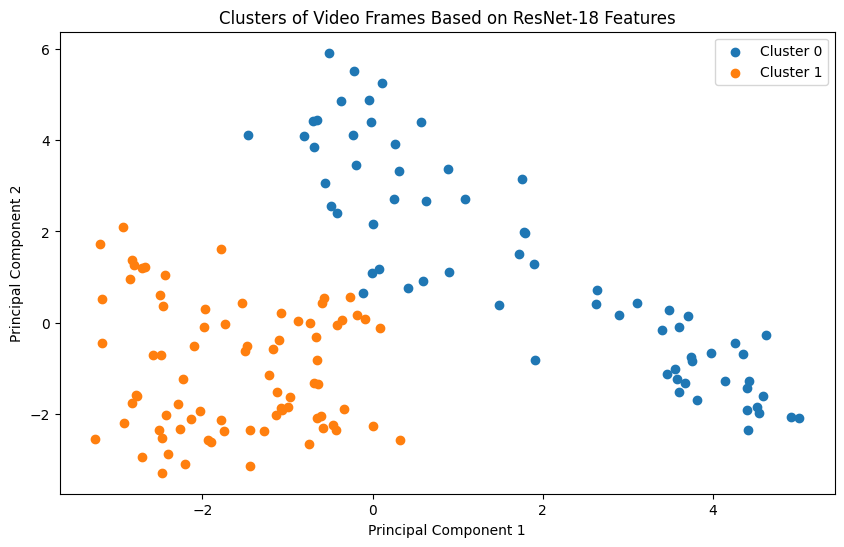

Frame cluster assignments saved to 187_0_RPSframe_cluster_assignments.csv


In [ ]:

N_CLUSTERS = 2
FRAME_SIZE = (224, 224)  

def extract_resnet_features(frame, model, device):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(FRAME_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    frame = transform(frame).unsqueeze(0).to(device)


    with torch.no_grad():
        features = model(frame)
    return features.cpu().numpy().flatten()


def process_video_frame_by_frame(video_path, model, device):
    cap = cv2.VideoCapture(video_path)
    features_list = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        features = extract_resnet_features(frame, model, device)
        features_list.append(features)

    cap.release()
    return np.array(features_list)

def cluster_features(features, n_clusters=N_CLUSTERS):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features)
    return kmeans.labels_, kmeans.cluster_centers_

# Function to visualize clusters using PCA
def visualize_clusters(features, labels, n_clusters=N_CLUSTERS):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features)

    plt.figure(figsize=(10, 6))
    for i in range(n_clusters):
        cluster_points = reduced_features[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

    plt.legend()
    plt.title('Clusters of Video Frames Based on ResNet-18 Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

def save_frame_cluster_assignments_to_csv(frame_labels, output_csv_path):
    df = pd.DataFrame({'Frame': np.arange(len(frame_labels)), 'Cluster': frame_labels})
    df.to_csv(output_csv_path, index=False)
    print(f'Frame cluster assignments saved to {output_csv_path}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18 = models.resnet18(pretrained=True)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])  
resnet18 = resnet18.to(device)
resnet18.eval()

video_path = '/content/drive/Shareddrives/mBSUS/Data/Raw Data/mbsus_case_videos/187-0_RPS.mp4'

resnet_features = process_video_frame_by_frame(video_path, resnet18, device)

frame_labels, _ = cluster_features(resnet_features)

visualize_clusters(resnet_features, frame_labels)

output_csv_path = '187_0_RPSframe_cluster_assignments.csv'
save_frame_cluster_assignments_to_csv(frame_labels, output_csv_path)


This was done to highlight the clinically relevant frames (frames with consolidation assigned by clinicians)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


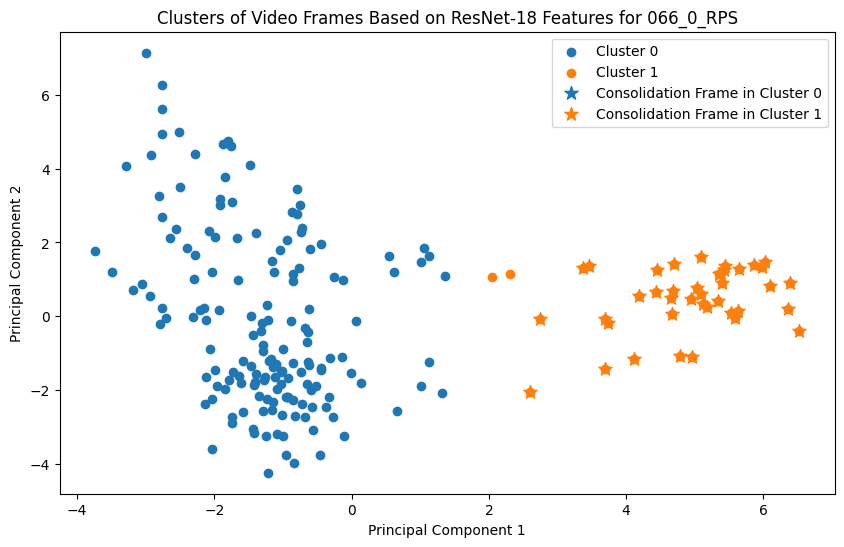

Frame cluster assignments saved to frame_cluster_assignments_173_0_RAT.csv


In [ ]:
N_CLUSTERS = 2
FRAME_SIZE = (224, 224)

def extract_resnet_features(frame, model, device):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(FRAME_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    frame = transform(frame).unsqueeze(0).to(device)

    with torch.no_grad():
        features = model(frame)
    return features.cpu().numpy().flatten()


def process_video_frame_by_frame(video_path, model, device):
    cap = cv2.VideoCapture(video_path)
    features_list = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        features = extract_resnet_features(frame, model, device)
        features_list.append(features)

    cap.release()
    return np.array(features_list)

def cluster_features(features, n_clusters=N_CLUSTERS):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features)
    return kmeans.labels_, kmeans.cluster_centers_

def visualize_clusters(features, labels, highlighted_frames, n_clusters=N_CLUSTERS):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features)

    plt.figure(figsize=(10, 6))
    cluster_colors = []
    for i in range(n_clusters):
        cluster_points = reduced_features[labels == i]
        scatter = plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
        cluster_colors.append(scatter.get_facecolor()[0])

 
    for idx in highlighted_frames:
        plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1],
                    color=cluster_colors[labels[idx]], marker='*', s=100)

    #This is done to be added to the legend
    plt.scatter([], [], color=cluster_colors[0], marker='*', s=100, label='Consolidation Frame in Cluster 0')
    if len(cluster_colors) > 1:
        plt.scatter([], [], color=cluster_colors[1], marker='*', s=100, label='Consolidation Frame in Cluster 1')

    plt.legend()
    plt.title('Clusters of Video Frames Based on ResNet-18 Features for 066_0_RPS')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

def save_frame_cluster_assignments_to_csv(frame_labels, output_csv_path):
    df = pd.DataFrame({'Frame': np.arange(len(frame_labels)), 'Cluster': frame_labels})
    df.to_csv(output_csv_path, index=False)
    print(f'Frame cluster assignments saved to {output_csv_path}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18 = models.resnet18(pretrained=True)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])
resnet18 = resnet18.to(device)
resnet18.eval()

video_path = '/content/drive/Shareddrives/mBSUS/Data/Raw Data/mbsus_case_videos/066-0_RPS.mp4'

resnet_features = process_video_frame_by_frame(video_path, resnet18, device)

frame_labels, _ = cluster_features(resnet_features)

csv_path = '/content/066_0_RPSframe_cluster_assignments.csv'
frame_cluster_df = pd.read_csv(csv_path)
highlighted_frames = frame_cluster_df[(frame_cluster_df['Frame'].between(161,201)) ]['Frame'].values

visualize_clusters(resnet_features, frame_labels, highlighted_frames)

output_csv_path = 'frame_cluster_assignments_173_0_RAT.csv'
save_frame_cluster_assignments_to_csv(frame_labels, output_csv_path)
